Author: Hem N Chaudhary

Date: Jan, 2024

Description: Summarization Techniques

In [ ]:
!pip install datasets
!pip install -U transformers
!pip install sentencepiece
!pip install git+https://github.com/huggingface/accelerate


  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-x8ydn5ww
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-x8ydn5ww
  Resolved https://github.com/huggingface/accelerate to commit 5ec00da2befbe9fa666f1bee8bdb1dd4daf713e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#Import CNN/DailyMail Dataset

from datasets import load_dataset
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')
print(f"Features: {dataset['train'].column_names}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  wa

Features: ['article', 'highlights', 'id']


In [ ]:
#excerpt from an article

sample = dataset["train"][1]
print(f"""Article(excerpt of 500 characters, total length: {len(sample["article"])}):""")

print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article(excerpt of 500 characters, total length: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


**Text Summarization Pipelines**

In [ ]:
#fixing the input text to 2,000 characters

sample_text=dataset["train"][1]["article"][:2000]

#We collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
!pip install nltk

In [ ]:
#separiting the summary sentences by a newline
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

**Summarization Baseline**

In [ ]:
#baseline for summarizing of news article

def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
#Using GPT-2 ; "TL;DR"-trick

from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
#T5

pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
#Bart

pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
#PEGASUS

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(".<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Comparing Different Summaries

print("Ground Truth")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")






Ground Truth
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
1.
Usain Bolt has now grabbed eight gold medals at world championships, equalling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix.
2.
In Moscow, Bolt raced to victory in the men's 4x100m relay, finishing to secure his third world championship medal.
3.
Gatlin, along with the United St

**Measuring the Quality of Generated Text**

In [ ]:
!pip install sacrebleu

In [ ]:
#loading metric from datasets

from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-14-966fe2c8feb0>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#example of bleu implementation

import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference = ["the cat is on the mat"])
results=bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"]=[np.round(p,2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["value"])

,value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
#example where prediction is almost correct
bleu_metric.add(
    prediction="the cat is on mat", reference = ["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"]=[np.round(p,2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["value"])

,value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [ ]:
#ROUGE
!pip install rouge_score


In [ ]:
rouge_metric = load_metric("rouge")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#Applying ROUGE to all the summaries generated by the models

reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.359551,0.091954,0.224719,0.292135
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


**Evaluating PEGASUS on the CNN/DailyMail Dataset**

In [ ]:
#evaluating the performance of the three sentence baseline

def evaluate_summaries_baseline(dataset, metric, column_text="article",
                                column_summary="highlights"):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add(predictions=summaries, references=dataset[column_summary])
  score=metric.compute()
  return score

In [ ]:
#running on 1,000 samples

test_sampled = dataset["test"].shuffle(seed=42).select(range(100))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.567578,0.22403,0.251723,0.251723


In [ ]:
#implementing the evaluation on PEGASUS model

from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
  """Yield successive n-sized chunks from list_of_elements."""
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i:i+batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(
      zip(article_batches, target_batches), total=len(article_batches)):

      inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                         padding="max_length", return_tensors="pt")
      summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                 attention_mask=inputs["attention_mask"].to(device),
                                 length_penalty=0.8, num_beams=8, max_length=128)
      decoded_summaries = [tokenizer.decode(s,skip_special_tokens=True,
                                            clean_up_tokenization_spaces=True) for s in summaries]
      decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
      metric.add_batch(predictions=decoded_summaries, references=target_batch)

  score = metric.compute()
  return score


In [ ]:
#load the model with AutoModelForSeq2SeqLM class, and evaluate it
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer,
                                   batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 13/13 [02:19<00:00, 10.76s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.421268,0.197094,0.296261,0.36464


**Training a Summarization Model**

In [ ]:
#Working with SAMSum dataset

dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
#evaluating PEGASUS on SAMSum

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


In [ ]:
#Confirm by running the full ROUGE evaluation on the test set

score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

100%|██████████| 103/103 [18:08<00:00, 10.57s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


**Fine-Tuning PEGASUS**

In [ ]:
import matplotlib.pyplot as plt

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


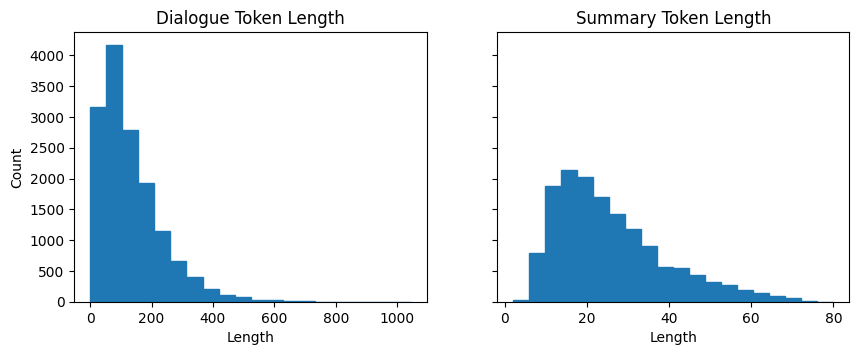

In [ ]:
#quick look at the length distribution of the input and outputs

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1,2,figsize=(10,3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.show()

In [ ]:
#Data collator for the trainer ; set max_len=1024 and 128 for dialogue and summary

def convert_examples_to_features(example_batch):
  input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                              truncation=True)
  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                 truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

columns = ["input_ids", "labels", "attention_mask"]

dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
#setup the decode inputs by shifting the label to the right by one

from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
#!pip uninstall accelerate
#!pip uninstall transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-afxmkrt7
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-afxmkrt7
  Resolved https://github.com/huggingface/accelerate to commit 5ec00da2befbe9fa666f1bee8bdb1dd4daf713e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#seting up the TrainingArguments, Trainer

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10, push_to_hub=True,
    evaluation_strategy="steps", eval_steps=500,
    save_steps=1e6, gradient_accumulation_steps=16
)

In [ ]:
#signing IN
from google.colab import userdata
key=userdata.get('huggingface')

from huggingface_hub import login
login(token=key, write_permission=True )

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#initializing the trainer w model, tokenizer, training arguments, data collator and training and evaluation

trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset= dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
# training

trainer.train()


You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.626500,1.484255


TrainOutput(global_step=920, training_loss=1.8238315105438232, metrics={'train_runtime': 2556.8709, 'train_samples_per_second': 5.762, 'train_steps_per_second': 0.36, 'total_flos': 5526698901602304.0, 'train_loss': 1.8238315105438232, 'epoch': 1.0})

In [ ]:
#evaluation after training
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary"
)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 410/410 [12:06<00:00,  1.77s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.431765,0.199677,0.341737,0.341799


In [ ]:
#push to the hub
trainer.push_to_hub("Training complete!")

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

events.out.tfevents.1705777870.2fd9b2152759.15955.0:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/pegasus-samsum/commit/8fc708215c0774389a8f0006cbb5acdefcfd28e6', commit_message='Training complete!', commit_description='', oid='8fc708215c0774389a8f0006cbb5acdefcfd28e6', pr_url=None, pr_revision=None, pr_num=None)

**Generating Dialogue Summaries**

In [ ]:
#summary generated on a sample examples

gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="hndc/pegasus-samsum")

print("Dialogue")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Hannah is looking for Betty's number. Amanda can't find it. Larry called Betty last time they were at the park together. Hannah would rather she text him.


In [ ]:
#how does the model do on custom unput?

custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think? Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])


Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Lewis used them recently and Leandro used them. Thom helped build a library by Hugging Face.
